In [322]:
from openparticle import ParticleOperator, Fock
from openparticle.utils import get_fock_basis, generate_matrix

import numpy as np
from scipy.linalg import expm
import scipy
from symmer import PauliwordOp
from functools import reduce
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)

In [323]:
#Parameters
Lambda = 2**4 - 1

Ef, Eb, g = 1, 1, 1

In [324]:
def get_bare_hamiltonian(Ef, Eb, g):
    return Ef * ParticleOperator('b0^ b0') + Eb * ParticleOperator('a0^ a0') +\
        g * ParticleOperator('b0^ b0') * (ParticleOperator('a0^') + ParticleOperator('a0')) 

In [325]:
def phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    return expm(-1j * Ef * t * a_dagger_a_matrix)

def padded_phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta I.. \otimes a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    padded_a_dagger_a_matrix = np.kron(np.eye(2), a_dagger_a_matrix)
    return expm(-1j * Ef * t * padded_a_dagger_a_matrix)

def fermion_Rz_gate(Eb, t):
    # exp(-1j theta b^dagger b)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    return expm(-1j * Eb * t / 2 * (I - Z))

def padded_fermion_Rz_gate(Eb, t, Lambda):
    # exp(-1j theta b^dagger b \otimes I...)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b = (I - Z) / 2
    b_dagger_b_padded = reduce(np.kron, [b_dagger_b, np.eye(Lambda + 1)])

    return expm(-1j * Eb * t * b_dagger_b_padded)

def naive_interaction_gate(g, t, Lambda):
    a_dagger_plus_a_matrix = generate_matrix(ParticleOperator('a0^') + ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0^') + ParticleOperator('a0'), Lambda))
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b_matrix = (I - Z)/2

    interaction_term = np.kron(b_dagger_b_matrix, a_dagger_plus_a_matrix)
    return expm(-1j * g * t * interaction_term)

def displacement_operator(alpha, Lambda):
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))

    return expm(
        alpha * adagger - alpha.conjugate() * a
    )

def sdf_displacement_operator(alpha, Lambda):
    #spin-dependent force (SDF)
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))
    X = PauliwordOp.from_dictionary({'X': 1.0}).to_sparse_matrix.toarray()
    return expm(
        np.kron(X, alpha * adagger - alpha.conjugate() * a)
    )

def native_interaction_gate(g, t, Lambda):
    alpha = -1j * g * t / 2
    Had = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
    padded_had = reduce(np.kron, [Had, np.eye(Lambda + 1)])
    padded_identity = np.array([[1, 0], [0, 1]])
    return np.kron(padded_identity, displacement_operator(alpha, Lambda)) @ (padded_had @ sdf_displacement_operator(-1 * alpha, Lambda) @ padded_had)

def trotterized_unitary(Ef, Eb, g, t, Lambda):
    R_theta_boson_gate = padded_phase_space_rotation_gate(Ef, t, Lambda)
    R_theta_fermion_gate = padded_fermion_Rz_gate(Eb, t, Lambda)
    R_theta_interaction_gate = naive_interaction_gate(g, t, Lambda)

    return R_theta_boson_gate @ R_theta_fermion_gate @ R_theta_interaction_gate


def trotter_evolve_statevector(t, Ef, Eb, g, Lambda, statevector):
    return trotterized_unitary(Ef, Eb, g, t, Lambda) @ statevector

In [326]:
def compute_expectations(statevector, t_arr, Ef, Eb, g, Lambda):
    
    num_fermion_list = []
    num_boson_list = []
    coherent_expval_list = []


    number_operator_ferm = ParticleOperator('b0^ b0')
    number_operator_ferm_matrix = generate_matrix(number_operator_ferm, get_fock_basis(number_operator_ferm, Lambda))
    padded_fermionic_number_operator_matrix = reduce(np.kron, [number_operator_ferm_matrix, np.eye(Lambda + 1)])

    number_operator_bose = ParticleOperator('a0^ a0')
    number_operator_bose_matrix = generate_matrix(number_operator_bose, get_fock_basis(number_operator_bose, Lambda))
    padded_bosonic_number_operator_matrix = reduce(np.kron, [np.eye(2), number_operator_bose_matrix])

    a_dagger_a = ParticleOperator('a0^') + ParticleOperator('a0')
    a_dagger_a_matrix = generate_matrix(a_dagger_a, get_fock_basis(a_dagger_a, Lambda))
    padded_a_dagger_a_matrix = reduce(np.kron, [np.eye(2), a_dagger_a_matrix])

    for t in t_arr:

        evolved_statevector = trotter_evolve_statevector(t, Ef, Eb, g, Lambda, statevector)
        num_fermion = evolved_statevector.T.conjugate() @ padded_fermionic_number_operator_matrix @ evolved_statevector
        num_boson = evolved_statevector.T.conjugate() @ padded_bosonic_number_operator_matrix @ evolved_statevector
        coherent_exp_val = evolved_statevector.T.conjugate() @ padded_a_dagger_a_matrix @ evolved_statevector

        num_fermion_list.append(num_fermion[0].real)
        num_boson_list.append(num_boson[0].real)
        coherent_expval_list.append(coherent_exp_val[0].real)

    return np.array(num_fermion_list), np.array(num_boson_list), np.array(coherent_expval_list)

In [327]:
fermion_state = np.array([[0, 1]]).reshape(-1, 1)
boson_state = np.zeros(Lambda + 1).reshape(-1, 1)
boson_state[0] = 1

statevector = np.kron(
    fermion_state,
    boson_state
)

t_arr = np.arange(0, 100, 0.1)
expvals = compute_expectations(statevector, t_arr, Ef, Eb, g, Lambda)

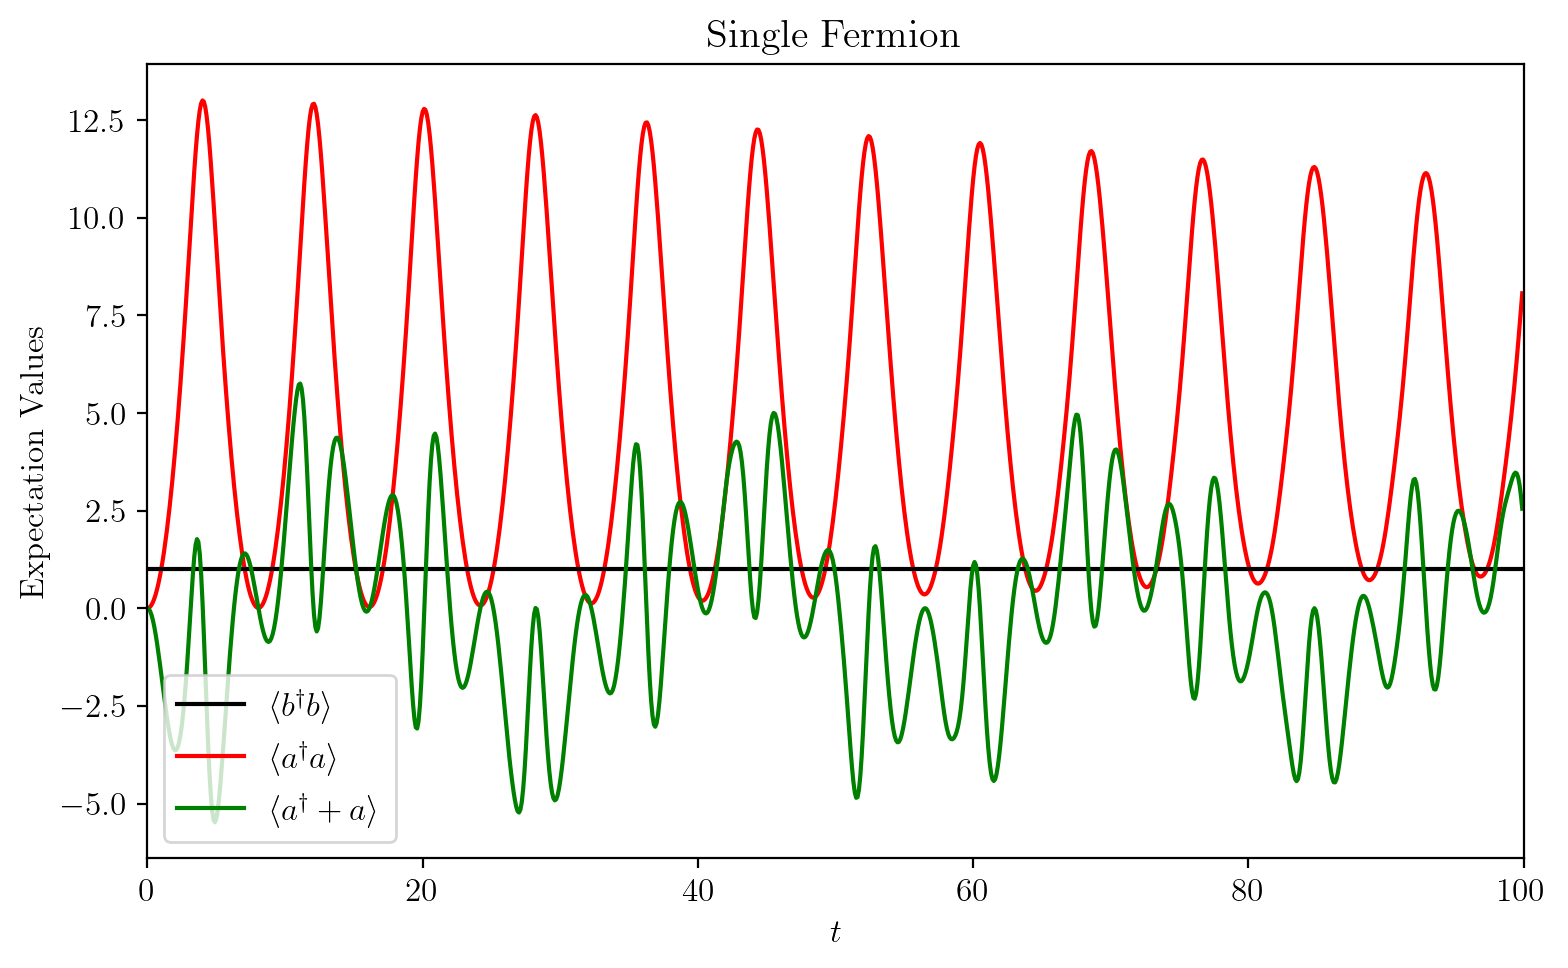

In [328]:
plt.figure(figsize=(8,5), dpi=200)

plt.plot(t_arr, expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$')
plt.plot(t_arr, expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$')


plt.plot(t_arr, expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$')
plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.title("Single Fermion")
plt.legend()
plt.tight_layout()
# plt.savefig('./single_fermion.pdf')

(array([ 12,  25,  37,  40,  50,  53,  62,  65,  74,  77,  88,  90, 100,
       102, 500, 898, 900, 910, 912, 923, 926, 935, 938, 947, 950, 960,
       963, 975, 988]), {})


(0.0, 0.1)

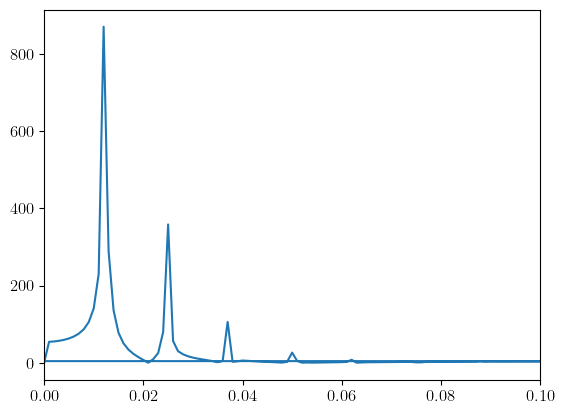

In [329]:
# freq_arr = np.fft.fftfreq(len(t_arr), d=t_arr[1] - t_arr[0])

N = len(t_arr)
freq_arr = np.fft.fftfreq(N)


fft_arr = scipy.fft.fft(np.array(expvals[1]).T[0] - np.average(expvals[1])).real

print(scipy.signal.find_peaks(np.abs(fft_arr)))
plt.plot(freq_arr, np.abs(fft_arr))
plt.xlim(0, 0.1)


In [330]:
fermion_state = np.array([[1, 0]]).reshape(-1, 1)
boson_state = np.zeros(Lambda + 1).reshape(-1, 1)
boson_state[0] = 1
boson_state = displacement_operator(alpha = -1j * g / 2, Lambda = Lambda) @ boson_state

statevector = np.kron(
    fermion_state,
    boson_state
)

t_arr = np.arange(0, 100, 0.1)
expvals = compute_expectations(statevector, t_arr, Ef, Eb, g, Lambda)

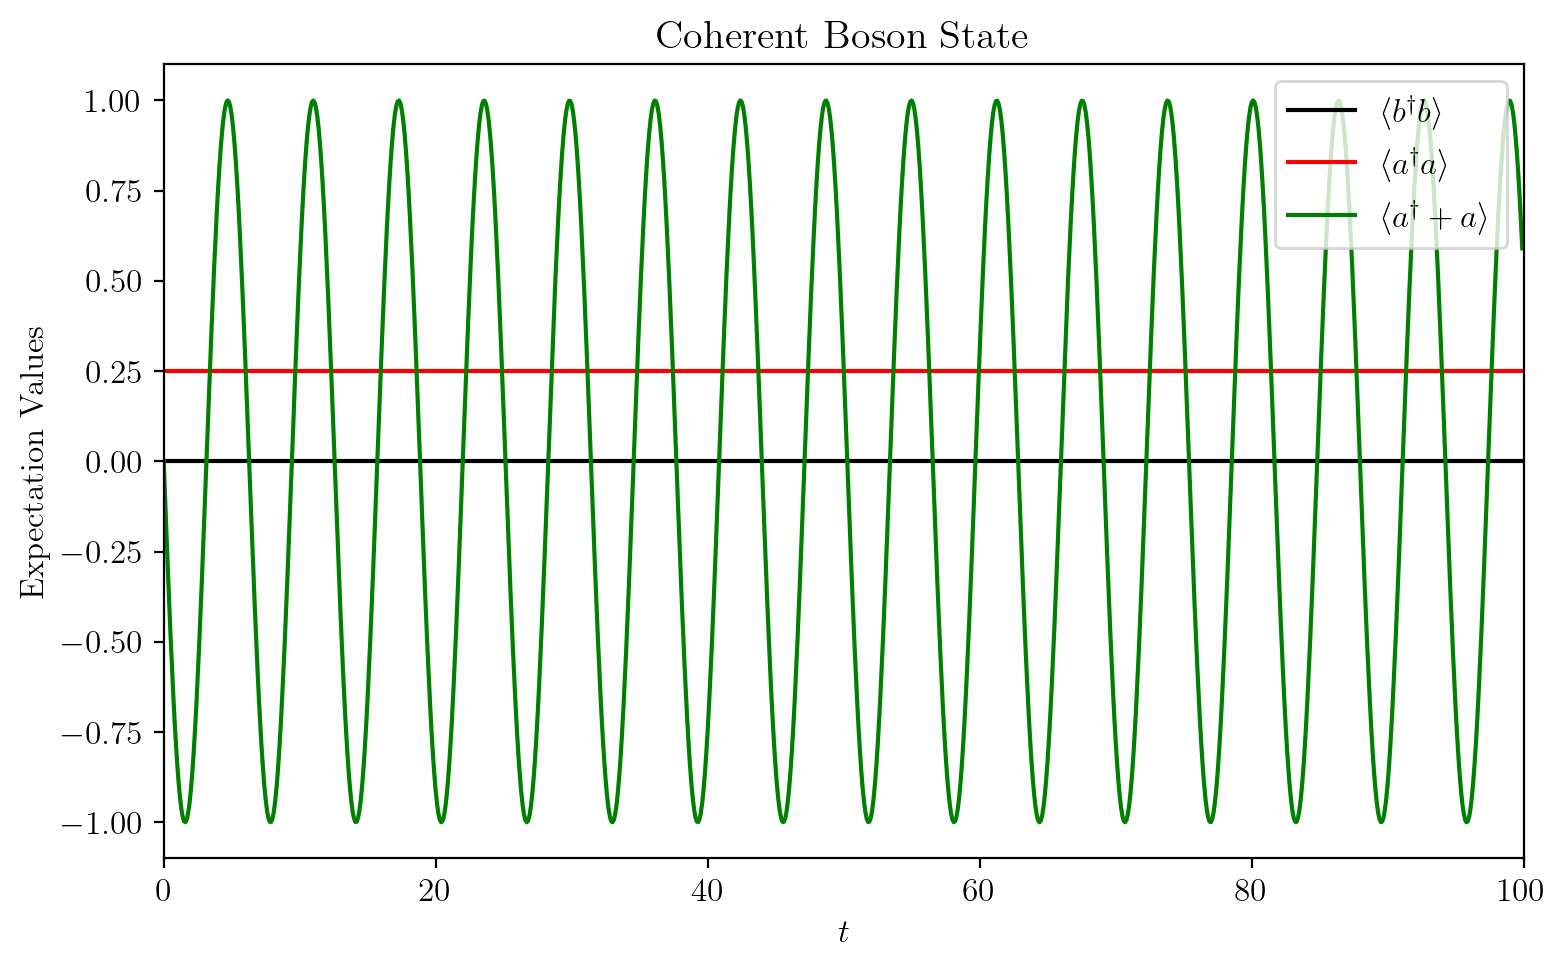

In [331]:
plt.figure(figsize=(8,5), dpi=200)

plt.plot(t_arr, expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$')
plt.plot(t_arr, expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$')


plt.plot(t_arr, expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$')
plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.title("Coherent Boson State")
plt.legend()
plt.tight_layout()
# plt.savefig("./coherent_state.pdf")

In [332]:
fermion_state = np.array([[0, 1]]).reshape(-1, 1)
boson_state = np.zeros(Lambda + 1).reshape(-1, 1)
boson_state[0] = 1
boson_state = displacement_operator(alpha = -1j * g / 2, Lambda = Lambda) @ boson_state

statevector = np.kron(
    fermion_state,
    boson_state
)

t_arr = np.arange(0, 100, 0.1)
expvals = compute_expectations(statevector, t_arr, Ef, Eb, g, Lambda)

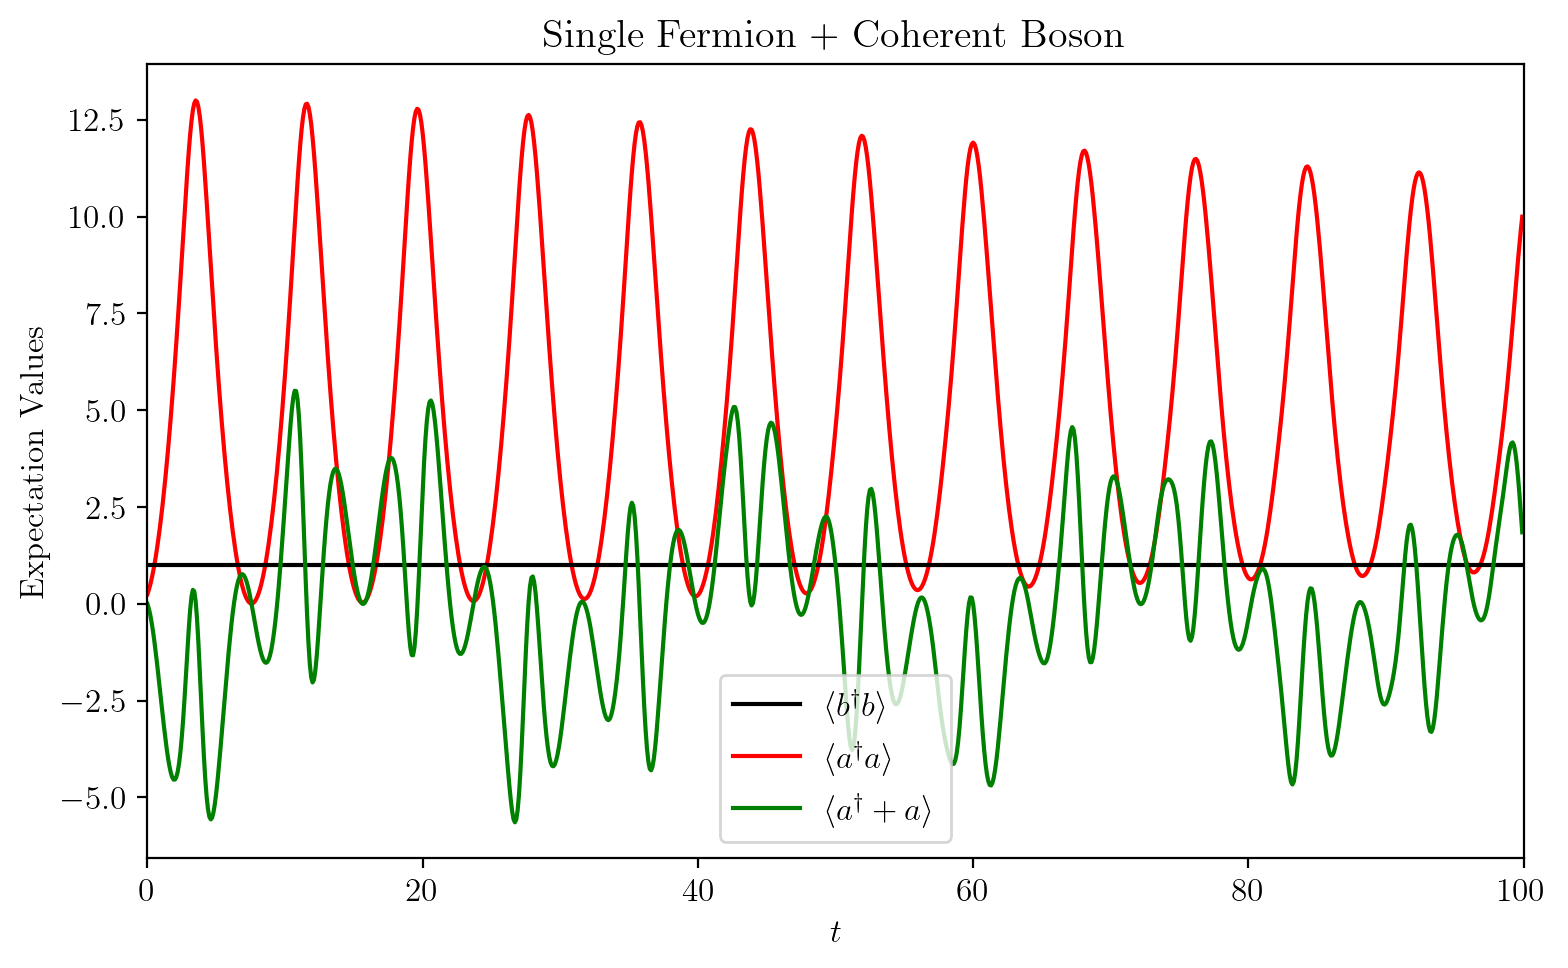

In [333]:
plt.figure(figsize=(8,5), dpi=200)

plt.plot(t_arr, expvals[0], color = 'k', label = r'$\langle b^\dagger b \rangle$')
plt.plot(t_arr, expvals[1], color = 'r', zorder = 1, label = r'$\langle a^\dagger a \rangle$')


plt.plot(t_arr, expvals[2], color = 'g', zorder = 2, label = r'$\langle a^\dagger + a \rangle$')
plt.xlim(0, 100)
plt.ylabel("Expectation Values")
plt.xlabel(r'$t$')
plt.title(r"Single Fermion $+$ Coherent Boson")
plt.legend()
plt.tight_layout()
# plt.savefig("./fermion_plus_coherent_state.pdf")